신경망을 이용한 비선형 모델의 회귀분석
http://www.gisdeveloper.co.kr/?p=8395


Using cuda device
(2, 68)
(2, 68)
(2, 68)
(2, 68)
(2, 68)
(2, 68)
(2, 68)
(2, 68)
(2, 68)
(2, 68)
Shape of X [N, C, F]: torch.Size([10, 2, 20])
Shape of Tensor y: torch.Size([10, 1]) torch.float32


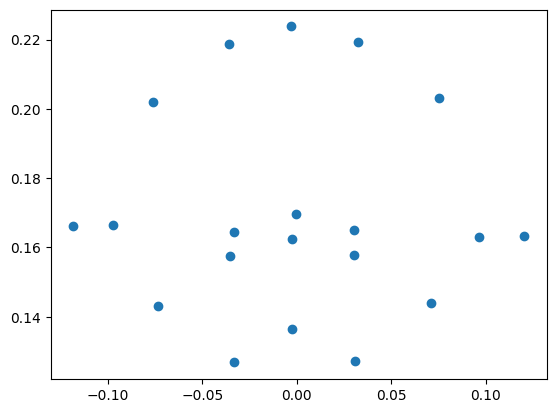

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dlib_index as DI
from FaceFeatureDataset import FaceFeatureDataset

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 10
epochs = 500



# 머리      headSize =0, headWidth = 1,
# 이마      foreheadPosition= 2,foreheadSize = 3,
# 턱        jawsPosition =4,jawsSize = 5,
# 아래턱    chinPosition = 6,chinSize = 7,chinPronounced = 8,
# 뺨        lowCheek = 9, cheekPosition = 10, cheekSize = 11,
# 귀        earsPosition = 12, earsRotation =13, earsSize = 14
# 눈        eyeSize = 15, eyePosition= 16, eyeDepth = 17, eyeRotation = 18, eyeDistance = 19, eyeSquint= 20,
# 코        noseSize,nosePosition,noseFlatten,nosePronounced,noseWidth,noseBridge,noseCurve,noseInclination,
# 입        mouthSize,mouthPosition,mouthPronounced,lipsSize

#eyeIndexes = ['eyeSize', 'eyePosition', 'eyeDepth', 'eyeRotation', 'eyeDistance', 'eyeSquint']
#featureIndexes = DI.LEFT_EYE
#labelIndexes = list(range(15, 21)) # eye 
# 입 특징들만 추출 하고 입의 크기 데이터하고만 테스트 해보자 


#featureIndexes = None
featureIndexes = DI.MOUSE
# labelIndexes = list([1])
labelIndexes = list([31])  # mouse size

training_data = FaceFeatureDataset(feature_file="./outimg/Train/facefeature.csv", feature_indexes=featureIndexes,
                                   label_file="./Dataset/Train/csv/train.csv", label_indexes=labelIndexes)
test_data = FaceFeatureDataset(feature_file="./outimg/Test/facefeature.csv", feature_indexes=featureIndexes,
                               label_file="./Dataset/Test/csv/test.csv", label_indexes=labelIndexes)


train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 데이터 로드 확인
for X, y in test_loader:
    # N , Channel, H= width W = height
    print(f"Shape of X [N, C, F]: {X.shape}")
    print(f"Shape of Tensor y: {y.shape} {y.dtype}")
    break
n_total_steps = len(train_loader)
print(y)
plt.scatter(X[0][0], X[0][1])
plt.show()


In [ ]:
#num_classes = len(eyeIndexes)
#print(num_classes)
num_classes = 1

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(2, 16, 3),   # 68 -> 66
            nn.MaxPool1d(2),        # 66 -> 33
            nn.ReLU())

        self.cnn2 = nn.Sequential(
            nn.Conv1d(16, 32, 4),   # 33 -> 30
            nn.MaxPool1d(2),        # 30-> 15
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Linear(528, 128), # 528 = 16 * 13
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
    

    def forward(self, x):
        x = self.cnn1(x)
        #x = self.cnn2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

model = NeuralNetwork().to(device)
print(model)
print(list(model.parameters()))


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn1): Sequential(
    (0): Conv1d(2, 16, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (cnn2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=528, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
[Parameter containing:
tensor([[[-0.2684, -0.0205, -0.2517],
         [-0.4045, -0.0596, -0.3115]],

        [[ 0.3148, -0.3487, -0.3702],
         [-0.4050,  0.2921,  0.0128]],

        [[-0.3447, -0.3714,  0.0906],
         [ 0.3357, -0.0406, -0.4002]],

        [[-0.2958, -0.0019, -0.2278],
         [ 0.1586,  0.0790,  0.0454]],

        [[ 0.3041,  0.1044, -0.0514],
         [-0.2057,  0.1521, -0.3704]],



In [ ]:
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)        
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('batch',  batch)
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)    
print("Done!")
print(list(model.parameters()))

Epoch 1
-------------------------------
batch 0
loss: 0.571794  [    0/  100]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
Epoch 2
-------------------------------
batch 0
loss: 0.436092  [    0/  100]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
Epoch 3
-------------------------------
batch 0
loss: 0.130082  [    0/  100]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
Epoch 4
-------------------------------
batch 0
loss: 0.255994  [    0/  100]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
Epoch 5
-------------------------------
batch 0
loss: 0.207485  [    0/  100]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
Epoch 6
-------------------------------
batch 0
loss: 0.156653  [    0/  100]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
Epoch 7
-------------------------------
batch 0
loss: 0.210492  [    0/  100]
batch 1
batch 2
batch 

In [ ]:
PATH = './face_eye.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    print('test size', size )
    # num_batches = len(dataloader)
    # model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)            
            print('pred =', pred)
            #print('loss', loss)
            #print('real', y)



In [ ]:

test(test_loader, model, criterion)

print("Done !")

test size 100
pred = tensor([[0.4743],
        [0.4494],
        [0.4665],
        [0.4828],
        [0.4611],
        [0.4061],
        [0.4408],
        [0.4066],
        [0.4392],
        [0.4199]], device='cuda:0')
pred = tensor([[0.4408],
        [0.4385],
        [0.4300],
        [0.4493],
        [0.4351],
        [0.3890],
        [0.4501],
        [0.4161],
        [0.4625],
        [0.4862]], device='cuda:0')
pred = tensor([[0.4870],
        [0.4160],
        [0.4351],
        [0.4132],
        [0.4505],
        [0.4279],
        [0.4365],
        [0.3977],
        [0.4508],
        [0.4476]], device='cuda:0')
pred = tensor([[0.4370],
        [0.4542],
        [0.4556],
        [0.4962],
        [0.4263],
        [0.4491],
        [0.4482],
        [0.4407],
        [0.4577],
        [0.4949]], device='cuda:0')
pred = tensor([[0.4758],
        [0.4525],
        [0.4618],
        [0.4992],
        [0.4729],
        [0.4280],
        [0.4584],
        [0.4134],
        [0.4326

In [ ]:
#print(training_data[0])

test_iter = iter(test_data)

with torch.no_grad():
    for x, y in test_iter:
        x = np.array([x])        
        x = torch.Tensor(x).to(device)
        pred = model(x)
        print(pred, y)


tensor([[0.4743]], device='cuda:0') [0.7514151]
tensor([[0.4494]], device='cuda:0') [0.3392321]
tensor([[0.4665]], device='cuda:0') [0.699237]
tensor([[0.4828]], device='cuda:0') [0.3948978]
tensor([[0.4611]], device='cuda:0') [0.7726646]
tensor([[0.4061]], device='cuda:0') [0.3179817]
tensor([[0.4408]], device='cuda:0') [0.3590497]
tensor([[0.4066]], device='cuda:0') [0.2156946]
tensor([[0.4392]], device='cuda:0') [0.7897764]
tensor([[0.4199]], device='cuda:0') [0.238782]
tensor([[0.4408]], device='cuda:0') [0.4150633]
tensor([[0.4385]], device='cuda:0') [0.4519213]
tensor([[0.4300]], device='cuda:0') [0.7632524]
tensor([[0.4493]], device='cuda:0') [0.777518]
tensor([[0.4351]], device='cuda:0') [0.5334069]
tensor([[0.3890]], device='cuda:0') [0.3720133]
tensor([[0.4501]], device='cuda:0') [0.3742987]
tensor([[0.4161]], device='cuda:0') [0.5546108]
tensor([[0.4625]], device='cuda:0') [0.5770053]
tensor([[0.4862]], device='cuda:0') [0.5383425]
tensor([[0.4870]], device='cuda:0') [0.3348